1. 프로젝트 목표
직원들의 이직 여부를 사전에 예측하고, 이직 가능성이 높은 직원군을 식별하여 리스크 완화 및 리텐션 전략을 수립함.

2. 데이터 전처리 및 준비
* 고정값 제거
* 이진 피처 > 0/1 변환
* 다중 범주형 피처 > Lable Encoding 적용
* 결측치 없음.

3. 클래스 불균형 처리
* scale_pos_weight = 5.2 설정 → 이직자 클래스 보완 학습
* scale_pos_weight = negative / positive = 1233 / 237 = 5.2
 
4. 모델링
* 사용 모델: XGBoostClassifier  Logistic Regression / Random Forest / LightGBM / CatBoost
* 성능 평가: 교차검증(Stratified KFold, n=5)
* 피처 선택: RFE (Recursive Feature Elimination) 기반 → 10개 핵심 피처 추출

5. SHAP 기반 인사이트 도출
* OverTime
* MonthlyIncome < 3500
* JobSatisfaction <= 2 (불만족 ~ 보통)
* YearWithCurrmanager < 2
* JobRole in ['Sales Executive', 'Laboratory Technician']
> 해당 조합에 해당하는 직원군은 이직률 45% 이상

6. 제안
* 업무환경 개선 - 야근 빈도 높은 부서에 대해 업무 재조정 or 자동화 도입 고려
* Jobsatisfaction 낮은 직원에 대한 1:1 상담
* 급여 정책 - 하위 25% 급여 구간 + 야근 많은 직원 대상 복지, 보상 기획
* 리텐션 시뮬레이션 - 고위험군 리텐션 프로그램 후 이직률 변화 A/B 설계






In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import shap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


## 1. 데이터 확인 
* 총 1,470명 직원, 35개 특성 보유 
* 타겟: Attrition(Yes/No) 이직 여부 
* 이직자 비율: 약 16% (class imbalance 존재)

클래스 불균형(Class Imbalance): 타겟 변수(예측할 값)의 범주(Class)간 비율 차이가 큰 상황

In [2]:
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()
df['Attrition'].value_counts(normalize=True)


Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

## 2. 데이터 확인 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
# 결측치 확인 
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [5]:
# 고정값 삭제
df.drop(['Over18', 'EmployeeNumber', 'StandardHours', 'EmployeeCount'], axis=1, inplace=True)

In [6]:
# 이진 피처 처리
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['OverTime'] = df['OverTime'].map({'No': 0, 'Yes': 1})
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,1,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,0,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,0,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,1,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,0,...,3,4,1,6,3,3,2,2,2,2


In [7]:
# Label Encoding 

# 범주형 피처 라벨 인코딩 (split 이전!!)
from sklearn.preprocessing import LabelEncoder
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## 3. 데이터 분포, 왜도, 타겟 간 상관성, 피처 분포 차이를 시각화로 확인 

In [8]:
df.corr()['Attrition'].sort_values()

TotalWorkingYears          -0.171063
JobLevel                   -0.169105
YearsInCurrentRole         -0.160545
MonthlyIncome              -0.159840
Age                        -0.159205
YearsWithCurrManager       -0.156199
StockOptionLevel           -0.137145
YearsAtCompany             -0.134392
JobInvolvement             -0.130016
JobSatisfaction            -0.103481
EnvironmentSatisfaction    -0.103369
WorkLifeBalance            -0.063939
TrainingTimesLastYear      -0.059478
DailyRate                  -0.056652
RelationshipSatisfaction   -0.045872
YearsSinceLastPromotion    -0.033019
Education                  -0.031373
Gender                     -0.029453
PercentSalaryHike          -0.013478
HourlyRate                 -0.006846
BusinessTravel              0.000074
PerformanceRating           0.002889
MonthlyRate                 0.015170
EducationField              0.026846
NumCompaniesWorked          0.043494
Department                  0.063991
JobRole                     0.067151
D

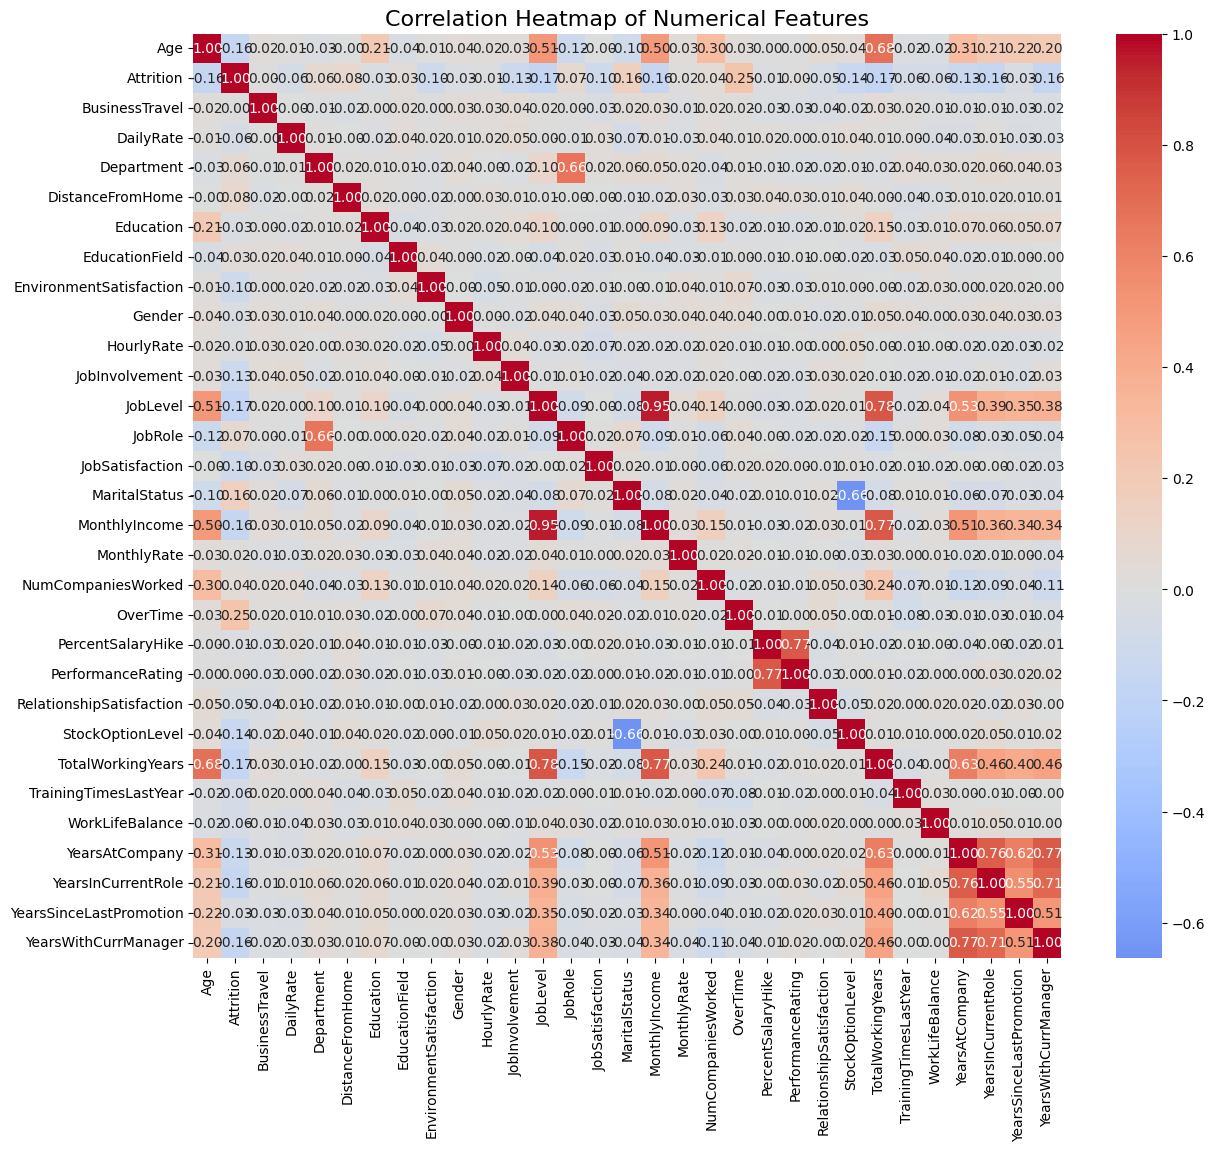

In [9]:
# 1. 수치형 피처만 선택해서 상관계수 계산
corr = df.select_dtypes(include='number').corr()

# 2. 히트맵 그리기
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

1. 중요한 타겟 상관피처 확인(Attrition 기준)
* OverTime, Joblevel, TotalWorkingYears, MonthlyIncome, YearsInCurrentRole, YearsWithCurrManager

2. 중복 피처 탐지 / 다중공선성 고려
상관계수에서 너무 높은 상관관계( > 0.8) 를 보이는 피처들은 중복이 의심된다. 

3. 설명력 없는 피처는 제거 고려 가능
* Education, PerformanceRating, DistanceFromHome, NumCompaniesWorked
> 모델 학습 - SHAP - RFE

4. 인사이트 도출
* 야근 많은 직원은 이직 가능성이 25% 더 높다.
* 급여 낮고 직급 낮은 직원의 이직 위험이 높다
* 직무 연속성과 상사 근속 관계가 이직에 영향을 미친다.



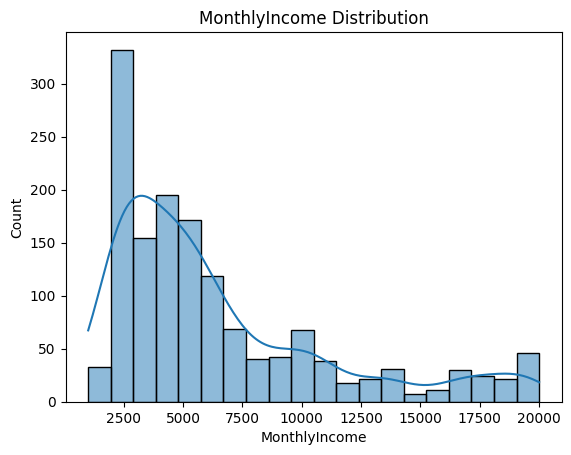

In [10]:
# 피처 분포 확인
sns.histplot(df["MonthlyIncome"], kde=True)
plt.title("MonthlyIncome Distribution")
plt.show()

그래프 해석: 급여가 낮은 사람이 많고, 일부만 고소득자이다. 

In [11]:
# 왜도(Skewness) 계산
df['MonthlyIncome'].skew()

1.3698166808390664

0 에 가까움 > 정규 분포 
0.5 or < -0.5 는 왜도 크다.(비대칭 분포)

In [12]:
# 로그 변환 
df['MonthlyIncome_log'] = np.log1p(df['MonthlyIncome'])

# 다시 확인
df['MonthlyIncome_log'].skew()

0.28644837630693515

로그 변환
* 모델이 급여를 비선형적으로 해석할 수 있음. 
* 로그 변환하면 분포가 좀 더 정규에 가까워 짐. 
* 회귀 모델을 쓸 경우에는 로그변환 효과가 큼. 


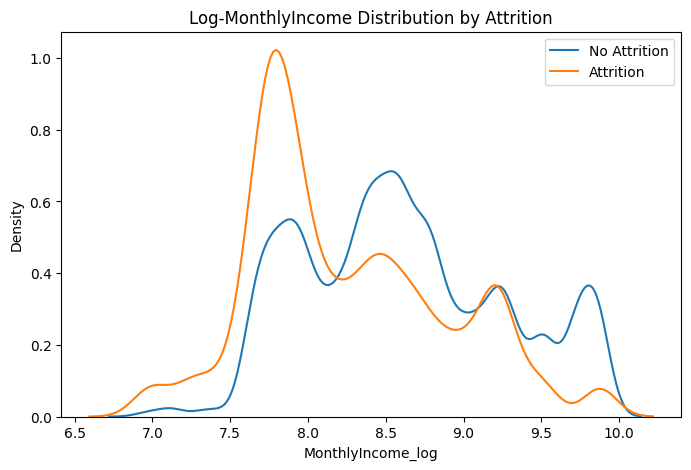

In [13]:
# 로그 변환된 컬럼 만들기
df['MonthlyIncome_log'] = np.log1p(df['MonthlyIncome'])

# 다시 KDE 시각화
plt.figure(figsize=(8,5))
sns.kdeplot(data=df[df['Attrition'] == 0], x='MonthlyIncome_log', label='No Attrition', bw_adjust=0.5)
sns.kdeplot(data=df[df['Attrition'] == 1], x='MonthlyIncome_log', label='Attrition', bw_adjust=0.5)
plt.title("Log-MonthlyIncome Distribution by Attrition")
plt.legend()
plt.show()

In [14]:
def analyze_feature_by_target(df, feature, target='Attrition'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print(f"\n▶️ Feature: {feature}")
    
    # 1. 왜도
    skew = df[feature].skew()
    print(f"Skewness: {skew:.2f}")
    
    # 2. 히스토그램
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title("Distribution")
    
    # 3. 타겟별 KDE
    plt.subplot(1, 3, 2)
    sns.kdeplot(data=df[df[target] == 0], x=feature, label='No Attrition')
    sns.kdeplot(data=df[df[target] == 1], x=feature, label='Attrition')
    plt.title("By Target (KDE)")
    
    # 4. 타겟별 Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(x=target, y=feature, data=df)
    plt.title("By Target (Boxplot)")

    plt.tight_layout()
    plt.show()



▶️ Feature: MonthlyIncome
Skewness: 1.37


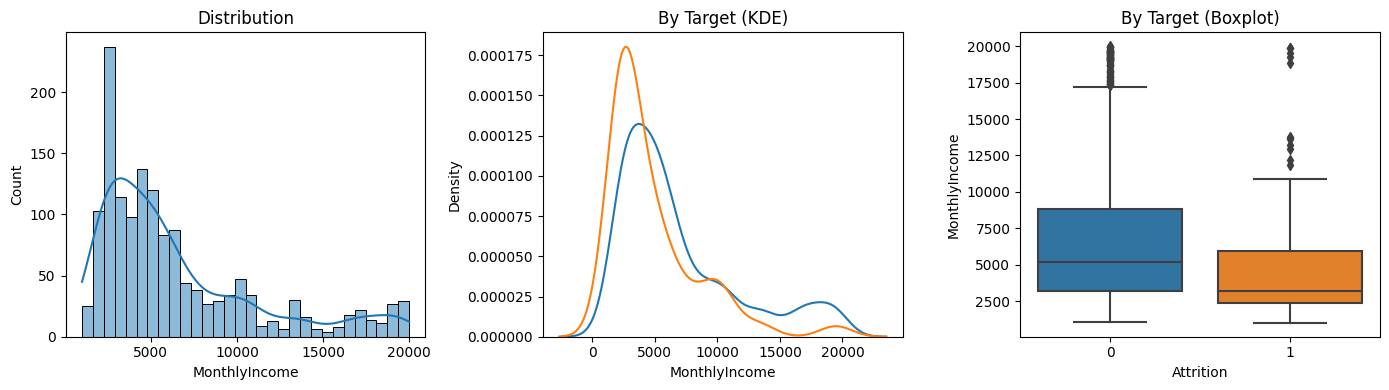

In [15]:
analyze_feature_by_target(df, 'MonthlyIncome')


▶️ Feature: DistanceFromHome
Skewness: 0.96


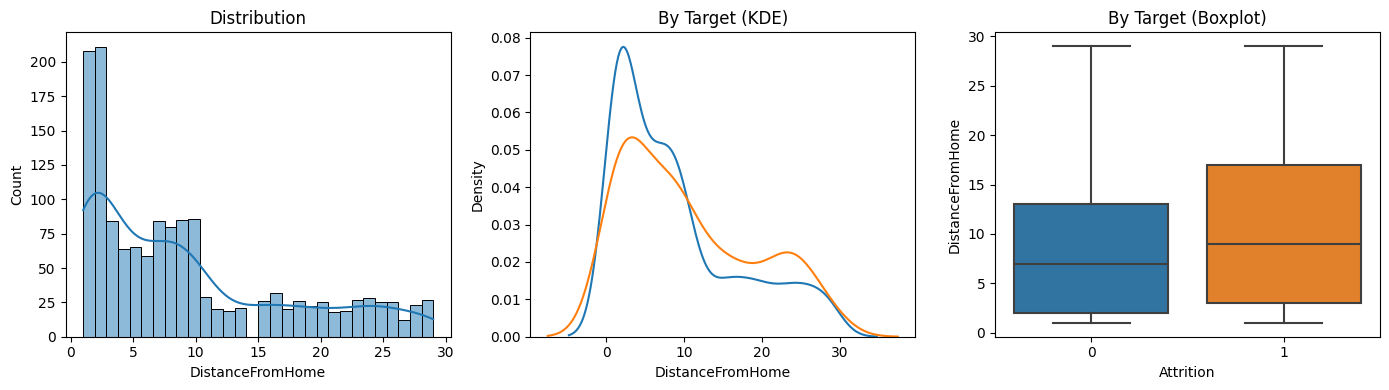

In [16]:
analyze_feature_by_target(df, 'DistanceFromHome')

## 4. 모델 학습

In [17]:
# X, y 설정 
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8673469387755102

분류 리포트:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.72      0.28      0.40        47

    accuracy                           0.87       294
   macro avg       0.80      0.63      0.66       294
weighted avg       0.85      0.87      0.84       294


혼동 행렬:
 [[242   5]
 [ 34  13]]


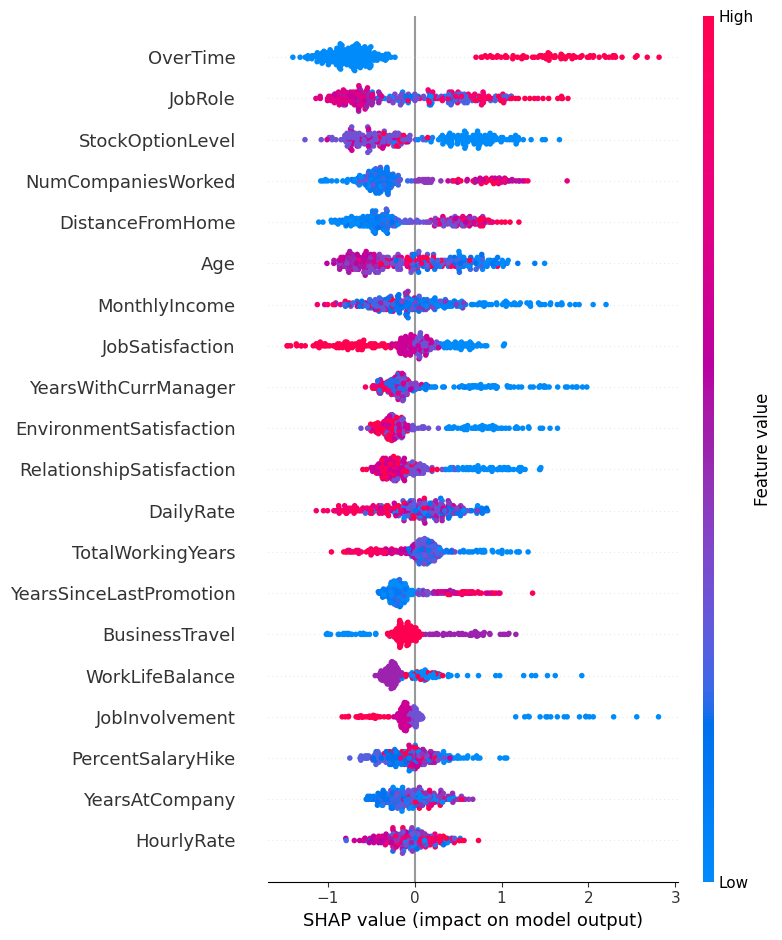

In [18]:
# SHAP explainer 만들기
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산 (검증용 데이터로)
shap_values = explainer(X_test)

# Summary Plot (전체 피처 중요도 + 영향 시각화)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

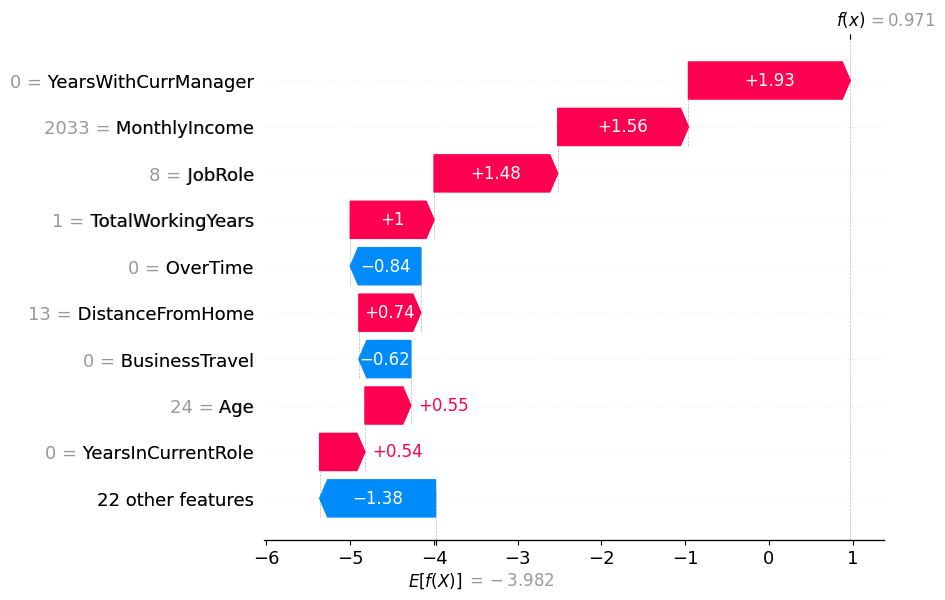

In [19]:
# Waterfall plot
# 샘플 학습
model.fit(X_train, y_train)

# SHAP explainer 생성 (트리 모델일 경우 TreeExplainer)
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 0번째 샘플에 대한 waterfall plot
shap.plots.waterfall(shap_values[0])

기준값 E[f(x)] = -3.982 
> 모델이 아무 정보도 없을 때의 초기 예측값

최종 예측값 f(x) = 0.971
> 이 직원이 이직할 확률이 매우 높다고 모델이 판단했다는 의미 (거의 1에 가까움)

파란색: 이직 예측을 낮춘 피처들 
빨간색: 이직 예측을 높인 피처들 

최종 해석: 이 직원은 상사와 일한지 얼마 안 되었고, 급여가 낮고, 신입이며, 젊고, 거리가 멀며, 야근이 없음에도 불구하고 이직 예측 점수가 0.971로 매우 높음. 
> 해당 직원은 적극적인 리텐션 조치가 필요하다. 

In [20]:
# f(x) 값들 추출 (예측값 = 모델의 로직 출력)
fx_values = shap_values.values.sum(axis=1) + explainer.expected_value

# 이직 확률 높은 샘플 상위 5개 인덱스 확인
top_indices = np.argsort(fx_values)[-5:][::-1]
print("이직 예측 확률이 높은 샘플 인덱스:", top_indices)

이직 예측 확률이 높은 샘플 인덱스: [200 276  92 287 223]


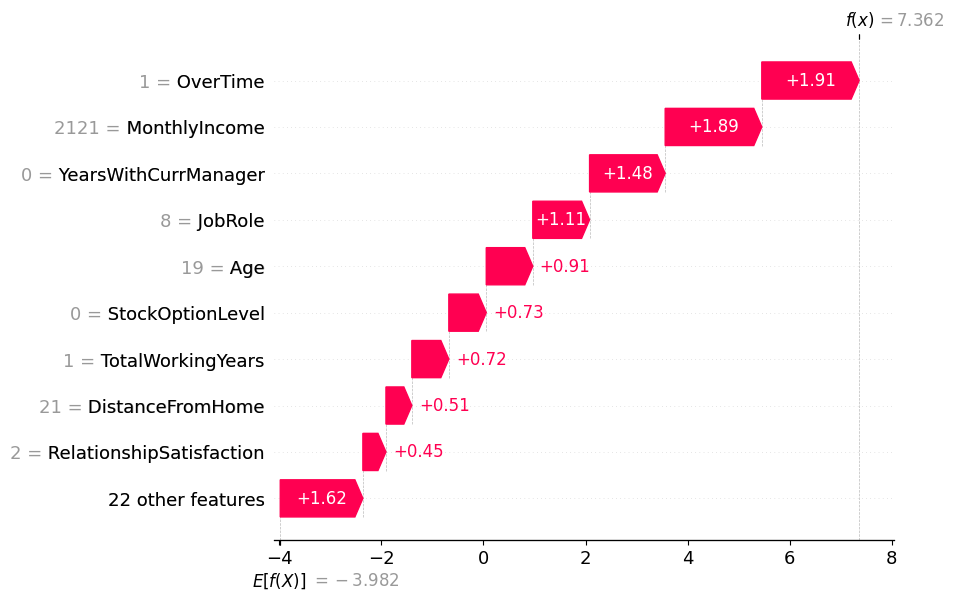

In [21]:
shap.plots.waterfall(shap_values[top_indices[0]])

In [22]:
# 1. RFE로 상위 10개 피처 선택 (기준 모델: 랜덤포레스트)
rfe_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=10)
X_selected = rfe.fit_transform(X, y)

# 선택된 피처 이름 확인 (선택 사항)
selected_features = X.columns[rfe.support_]
print("선택된 피처:\n", selected_features)

# 2. XGBoost 모델로 학습 및 평가
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_selected, y, cv=cv, scoring='accuracy')

print(f"\n🎯 XGBoost (선택된 10개 피처) 교차검증 평균 정확도: {scores.mean():.4f}")

선택된 피처:
 Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'OverTime', 'TotalWorkingYears', 'YearsAtCompany',
       'MonthlyIncome_log'],
      dtype='object')

🎯 XGBoost (선택된 10개 피처) 교차검증 평균 정확도: 0.8367


In [23]:
# X, y 설정 
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

pos = y_train.sum()
neg = len(y_train) - pos
scale = neg / pos

# 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=scale, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))

정확도: 0.8571428571428571

분류 리포트:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.59      0.34      0.43        47

    accuracy                           0.86       294
   macro avg       0.74      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294


혼동 행렬:
 [[236  11]
 [ 31  16]]


In [24]:
# 결과 저장용
results = []

# 공통 함수 정의
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n📌 {name} 결과")
    print(f"Accuracy: {acc:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Recall': recall,
        'AUC': auc
    })

# 1. Logistic Regression (스케일링 필요)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
evaluate_model('Logistic Regression', lr_pipeline)

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
evaluate_model('Random Forest', rf)

# 3. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model('XGBoost', xgb)

# 4. LightGBM
lgbm = LGBMClassifier(random_state=42)
evaluate_model('LightGBM', lgbm)

# 5. CatBoost (silent=True)
cat = CatBoostClassifier(verbose=0, random_state=42)
evaluate_model('CatBoost', cat)

# 결과 DataFrame 출력
results_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)
print("\n🎯 모델 성능 비교 결과 (Recall 기준 내림차순 정렬):")
display(results_df)


📌 Logistic Regression 결과
Accuracy: 0.8776, Recall: 0.3830, AUC: 0.8081
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       247
           1       0.72      0.38      0.50        47

    accuracy                           0.88       294
   macro avg       0.81      0.68      0.72       294
weighted avg       0.86      0.88      0.86       294


📌 Random Forest 결과
Accuracy: 0.8265, Recall: 0.0638, AUC: 0.7805
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       247
           1       0.30      0.06      0.11        47

    accuracy                           0.83       294
   macro avg       0.57      0.52      0.50       294
weighted avg       0.76      0.83      0.78       294


📌 XGBoost 결과
Accuracy: 0.8673, Recall: 0.2766, AUC: 0.7747
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.72      0.28      

,Model,Accuracy,Recall,AUC
0,Logistic Regression,0.877551,0.382979,0.808080
2,XGBoost,0.867347,0.276596,0.774744
3,LightGBM,0.853741,0.234043,0.794642
4,CatBoost,0.860544,0.191489,0.812645
1,Random Forest,0.826531,0.063830,0.780515
